# 데이터 전처리 방안 수정
- TF-IDF 제거
- 피처 변경 : type에 대한 전처리 방식 변경, subtype 삭제, season_type 삭제
- 결측치 
    - 판매량 관련 결측치를 0으로 대체
    - 가격 관련 피처는 nan으로 유지
    - 테스트 데이터를 고려하여, 모델이 최대한 많은 0의 데이터를 학습하도록 함
- 모든 전처리를 마친 후, 상점별 아이템 월간 판매량에 대한 피처를 (0, 20)으로 클리핑

# Module

In [1]:
import gc
import calendar
import re
from itertools import product
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
plt.style.use("seaborn-v0_8-white")

# Data

In [2]:
data_path = "./data/"

sales_train = pd.read_csv(data_path + 'sales_train.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
shops = pd.read_csv(data_path + 'shops.csv')

test = pd.read_csv(data_path + 'test.csv')
sub = pd.read_csv(data_path + 'sample_submission.csv')

print('Before Filter ShopID:', len(sales_train))
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print('After Filter ShopID :', len(sales_train))

Before Filter ShopID: 2935849
After Filter ShopID : 2413246


In [3]:
# def downcast(df, include_floats=None, verbose=True):
#     start_memory = df.memory_usage().sum() / 1024**2
    
#     if include_floats is None:
#         include_floats = []

#     for col in df.columns:
#         dtype_name = df[col].dtype.name
        
#         if dtype_name == 'object':
#             pass
            
#         elif dtype_name == 'bool':
#             df[col] = df[col].astype('int8')
            
#         elif dtype_name.startswith('int') or (df[col]%1==0).all():
#             df[col] = pd.to_numeric(df[col], downcast='integer')
            
#         elif dtype_name.startswith('float'):
#             if col in include_floats:
#                 df[col] = pd.to_numeric(df[col], downcast='float')

#     end_memory = df.memory_usage().sum() / 1024**2
#     if verbose:
#         print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
#     return df

In [4]:
def downcast(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col]%1==0).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif dtype_name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_memory = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print(f"Memory usage reduced from {start_memory:.2f} MB to {end_memory:.2f} MB")
        
    return df

In [5]:
train = []

for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num'] == i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num'] == i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

# idx features        
idx_features = ['date_block_num', 'shop_id', 'item_id']
train = pd.DataFrame(np.vstack(train), columns=idx_features)

test['date_block_num'] = 34
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


# Feature Engineering

## Outliers
- `-1` 같은 음수값은 반품을 의미할 수 있음. 제거하지 않고 `item_cnt_month`로 집계

In [6]:
print("Before : ",len(sales_train))
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]
print("After item_cnt_day : ",len(sales_train))
sales_train = sales_train[sales_train['item_price'] < 50000]
print("After item_price : ",len(sales_train))

Before :  2413246
After item_cnt_day :  2413244
After item_price :  2413241


## Define function

In [7]:
def add_mean_features(df: pd.DataFrame, groupby_features: list, mean_feature_list: list = None):
    col_name = [col for col in groupby_features if col != 'date_block_num']
    base_name = '_'.join([col.replace('_id', '') for col in col_name])
    feature_name = f'{base_name}_avg_date_sales'
    
    agg_rules = {
        feature_name: ('item_cnt_month', 'mean')
    }
    group = df.groupby(groupby_features).agg(**agg_rules).reset_index()
    df = df.merge(group, on=groupby_features, how='left')
    del group
    
    if mean_feature_list is not None:
        mean_feature_list.append(feature_name)
    return df


def add_lag_features(df: pd.DataFrame, key_features: list, lag_feature_cols: list, lag_period: list):
    df_result = df.copy()

    for i in lag_period:
        df_lag = df[key_features + lag_feature_cols].copy()
        df_lag['date_block_num'] += i
        lag_col_names = {col: f'{col}_lag_{i}' for col in lag_feature_cols}
        df_lag = df_lag.rename(columns=lag_col_names)
        df_result = pd.merge(df_result, df_lag, on=key_features, how='left')

    all_lag_cols = [f'{col}_lag_{i}' for col in lag_feature_cols for i in lag_period]
    for col in all_lag_cols:
        if 'cnt' in col or 'sales' in col:
            df_result[col] = df_result[col].fillna(0)
    return df_result

## shops

In [8]:
# 데이터 수정
sales_train.loc[sales_train['shop_id']==0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id']==1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id']==10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id']==39, 'shop_id'] = 40

test.loc[test['shop_id']==0, 'shop_id'] = 57
test.loc[test['shop_id']==1, 'shop_id'] = 58
test.loc[test['shop_id']==10, 'shop_id'] = 11
test.loc[test['shop_id']==39, 'shop_id'] = 40

shops['city'] = shops['shop_name'].str.split(' ').str[0]
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'

# 특수 상점(온라인/이동식)을 별도 도시 'Special'로 분류
shops.loc[shops['city'].isin(['Выездная', 'Интернет-магазин']), 'city'] = 'Special'

# 약어 및 오표기 수정
shops.loc[shops['city'] == 'СПб', 'city'] = 'Санкт-Петербург'
shops.loc[shops['city'] == 'Н.Новгород', 'city'] = 'НижнийНовгород'
shops.loc[shops['city'] == 'РостовНаДону', 'city'] = 'Ростов-на-Дону'

# 모스크바 위성 도시 통합
moscow_satellite_cities = ['Жуковский', 'Мытищи', 'Химки', 'Чехов', 'Балашиха', 'Сергиев']
shops.loc[shops['city'].isin(moscow_satellite_cities), 'city'] = 'МоскваОбласть'

# 쇼핑몰/센터를 나타내는 러시아어 약어로 상점 구분
mall_keywords = ['ТЦ', 'ТРК', 'ТРЦ', 'MALL', 'Молл']
is_mall = shops['shop_name'].apply(lambda x: any(keyword in x for keyword in mall_keywords))

shops['shop_type'] = np.where(is_mall, 'Mall', 'Standalone')

for col in ['city', 'shop_type']:
    encoder = LabelEncoder()
    shops[col] = encoder.fit_transform(shops[col])

shops = shops.drop(columns=["shop_name"])

## items

In [9]:
first_sale_mon = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_month'] = items['item_id'].map(first_sale_mon).fillna(34)

##### 월별 아이템 평균가격

In [10]:
date_item_avg_price = sales_train.groupby(['date_block_num', 'item_id']).agg(date_item_avg_price=('item_price', 'mean')).reset_index()

### TF-IDF

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

items = items.merge(item_categories, on='item_category_id', how='left')
items['item_full_name'] = items['item_category_name'] + ' ' + items['item_name']
items['clean_item_name'] = items['item_full_name'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=1000)
item_name_tfidf = tfidf.fit_transform(items['clean_item_name'])

n_comp = 20
svd = TruncatedSVD(n_components=n_comp, random_state=2025)
item_name_svd = svd.fit_transform(item_name_tfidf.toarray())

svd_cols = [f'item_name_svd_{i}' for i in range(n_comp)]
item_name_svd_df = pd.DataFrame(item_name_svd, columns=svd_cols)
item_name_svd_df['item_id'] = items['item_id']

items = items.merge(item_name_svd_df, on='item_id', how='left')
items.head()

,item_name,item_id,item_category_id,first_sale_month,item_category_name,item_full_name,clean_item_name,item_name_svd_0,item_name_svd_1,item_name_svd_2,...,item_name_svd_10,item_name_svd_11,item_name_svd_12,item_name_svd_13,item_name_svd_14,item_name_svd_15,item_name_svd_16,item_name_svd_17,item_name_svd_18,item_name_svd_19
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,34.0,Кино - DVD,Кино - DVD ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) ...,кино dvd во власти наваждения пласт d,0.343956,-0.072842,-0.003275,...,-0.001110,-0.002210,-0.001803,0.000177,0.001900,-0.000262,0.001198,0.000887,-0.000388,-0.001200
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.0,Программы - Для дома и офиса (Цифра),Программы - Для дома и офиса (Цифра) !ABBYY Fi...,программы для дома и офиса цифра abbyy finere...,0.004050,0.000853,0.029947,...,0.204098,0.035920,0.267784,0.008613,-0.016817,-0.096697,0.014582,-0.022068,0.053093,0.025555
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,34.0,Кино - DVD,Кино - DVD ***В ЛУЧАХ СЛАВЫ (UNV) ...,кино dvd в лучах славы unv ...,0.927008,-0.195910,-0.009256,...,-0.004155,-0.007278,-0.006979,0.001087,0.001387,0.001394,-0.001082,0.001154,-0.001486,-0.000554
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,34.0,Кино - DVD,Кино - DVD ***ГОЛУБАЯ ВОЛНА (Univ) ...,кино dvd голубая волна univ ...,0.927008,-0.195910,-0.009256,...,-0.004155,-0.007278,-0.006979,0.001087,0.001387,0.001394,-0.001082,0.001154,-0.001486,-0.000554
4,***КОРОБКА (СТЕКЛО) D,4,40,34.0,Кино - DVD,Кино - DVD ***КОРОБКА (СТЕКЛО) ...,кино dvd коробка стекло d,0.355035,-0.075058,-0.003462,...,0.003782,-0.000817,0.012545,0.000217,-0.001406,-0.008786,0.001147,-0.000997,0.002054,0.000699


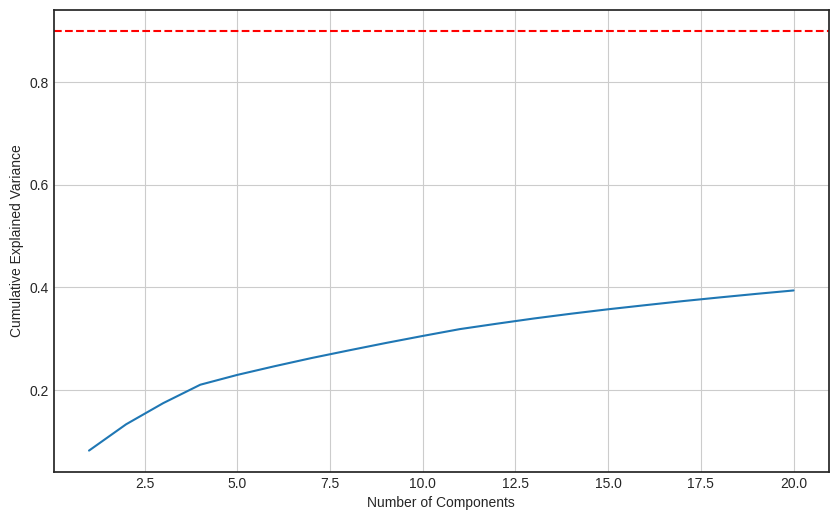

원본 데이터의 90%를 설명하기 위한 차원 수: 1


In [12]:
cumsum = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(cumsum) + 1), y=cumsum)
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.show()

d = np.argmax(cumsum >= 0.9) + 1
print(f"원본 데이터의 90%를 설명하기 위한 차원 수: {d}")

In [13]:
items = items.drop(columns=['clean_item_name', 'item_name', 'item_full_name', 'item_category_name'])
gc.collect()

153

## item_categories

In [14]:
def clean_category_type(df):
    df['type'] = df['item_category_name'].apply(lambda x: x.split('-')[0].strip())
    df['type'] = df['type'].apply(lambda x: 'Игры' if 'Игры' in x else x) # 모든 게임(PC, Android, Mac)을 'Игры'로 통합
    df['type'] = df['type'].apply(lambda x: 'Карты оплаты' if 'Карты' in x else x) # 카드류 통합
    df['type'] = df['type'].apply(lambda x: 'Чистые носители' if 'Чистые' in x else x) # 미디어류 통합
    print(df['type'].value_counts())
    common_types = df['type'].value_counts()
    etc_types = common_types[common_types < 4].index.tolist()
    df['type'] = df['type'].apply(lambda x: 'etc' if x in etc_types else x)
    return df

item_categories = clean_category_type(item_categories)
item_categories['type'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories = item_categories.drop('item_category_name', axis=1)
item_categories['type'].value_counts()

type
Игры                15
Книги               13
Подарки             12
Игровые консоли      8
Аксессуары           7
Музыка               6
Программы            6
Кино                 5
Карты оплаты         4
Служебные            2
Чистые носители      2
PC                   1
Билеты (Цифра)       1
Доставка товара      1
Элементы питания     1
Name: count, dtype: int64


type
3    15
6    13
8    12
0     8
2     8
1     7
7     6
9     6
5     5
4     4
Name: count, dtype: int64

## revenue

In [15]:
sales_train['revenue'] = sales_train['item_cnt_day'] * sales_train['item_price']

## set up matrix

In [16]:
data_files = [sales_train, shops, items, item_categories]
for file in data_files:
    file = downcast(file)

Memory usage reduced from 147.29 MB to 87.45 MB
Memory usage reduced from 0.00 MB to 0.00 MB
Memory usage reduced from 3.89 MB to 1.78 MB
Memory usage reduced from 0.00 MB to 0.00 MB


In [17]:
group = sales_train.groupby(idx_features).agg(
    item_cnt_month = ('item_cnt_day', 'sum'),
    transaction_cnt = ('item_cnt_day', 'count'),
    date_revenue = ('revenue', 'sum')
).reset_index()

train = train.merge(group, on=idx_features, how='left')
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(date_item_avg_price, on=['date_block_num', 'item_id'], how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')
all_data.head()

/tmp/ipykernel_16828/101271298.py:8: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True, keys=idx_features)


,date_block_num,shop_id,item_id,item_cnt_month,transaction_cnt,date_revenue,city,shop_type,item_category_id,first_sale_month,...,item_name_svd_12,item_name_svd_13,item_name_svd_14,item_name_svd_15,item_name_svd_16,item_name_svd_17,item_name_svd_18,item_name_svd_19,date_item_avg_price,type
0,0,59,22154,1.0,1.0,999.0,24,0,37,0,...,0.013937,-0.003903,0.002876,-0.004709,-0.002156,-0.001261,-0.005914,0.000512,999.00,5
1,0,59,2552,NaN,NaN,NaN,24,0,58,0,...,-0.068120,0.036135,-0.016942,-0.046025,-0.003580,-0.034587,0.055813,-0.018581,899.00,7
2,0,59,2554,NaN,NaN,NaN,24,0,58,0,...,-0.045888,-0.018761,0.000624,-0.050743,0.006053,0.012731,-0.034054,-0.003083,1709.05,7
3,0,59,2555,NaN,NaN,NaN,24,0,56,0,...,-0.029353,0.037173,-0.010307,-0.039375,0.006050,-0.092118,0.291104,0.129827,1099.00,7
4,0,59,2564,NaN,NaN,NaN,24,0,59,0,...,0.016328,0.004033,0.012936,0.024760,0.018163,-0.026524,0.166645,-0.001065,349.00,7


In [18]:
temp = all_data.isna().sum()
temp[temp > 0]

item_cnt_month         7513150
transaction_cnt        7513150
date_revenue           7513150
date_item_avg_price     214277
dtype: int64

> 결측치 처리 방향

- `item_cnt_month`, `transaction_cnt`, `date_revenue`는 판매가 없어 nan으로 표시된 걸로 추정 -> 결측치를 0으로 대체
- `date_item_avg_price`는 nan 유지

In [19]:
fill_zero_cols = ['item_cnt_month', 'transaction_cnt', 'date_revenue']
all_data[fill_zero_cols] = all_data[fill_zero_cols].fillna(0)

In [20]:
all_data[all_data['date_item_avg_price'].isna()]['date_block_num'].value_counts()

date_block_num
34    214200
14        39
11        38
Name: count, dtype: int64

In [21]:
need_lag_list = []
long_lag_list = []
features_to_drop = []

need_lag_list.append('transaction_cnt')
long_lag_list.extend(['item_cnt_month', 'date_item_avg_price'])
all_data = downcast(all_data)

Memory usage reduced from 1184.97 MB to 907.63 MB


In [22]:
del shops, items, item_categories, group

## month, days

In [23]:
all_data['month'] = all_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)
all_data.groupby('month')['item_cnt_month'].mean().reset_index()

,month,item_cnt_month
0,0,0.361002
1,1,0.334841
2,2,0.350510
3,3,0.305403
4,4,0.301577
5,5,0.314516
6,6,0.294632
7,7,0.335717
8,8,0.357936
9,9,0.323847


- 12월의 평균 판매량이 특히 높게 나타남. 1월도 비교적 높음
- 3월과 9월의 평균 판매량이 상대적으로 높음(신학기 영향 예상)
- 테스트 데이터에 해당하는 11월은 평균 판매량이 1년 중 가장 낮음

In [24]:
# # 0: Low (11월 포함), 1: Normal, 2: High, 3: Peak
# season_dict = {
#     11: 3, # 연말
#     0: 2, 2: 2, 8: 2, # 0: 연초 / 2, 8: 신학기 
#     7: 2, 1:2, # 7: 저조한 6대비 판매량 회복. 신학기 준비
#     3: 1, 4: 1, 5: 1, 6:1, 9: 1, # 평범
#     10: 0  # 6: 비수기, 휴가철 / 10: pre holiday
# }

# all_data['season_type'] = all_data['month'].map(season_dict).astype('int8')

In [25]:
def count_weekends(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    
    _, last_day = calendar.monthrange(year, month)
    dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-{last_day}')
    weekend_count = dates.weekday.isin([5, 6]).sum()
    
    return weekend_count

weekend_map = {i: count_weekends(i) for i in range(35)}
all_data['num_weekends'] = all_data['date_block_num'].map(weekend_map).astype('int8')
all_data[['date_block_num', 'month', 'num_weekends']].head()

,date_block_num,month,num_weekends
0,0,0,8
1,0,0,8
2,0,0,8
3,0,0,8
4,0,0,8


In [26]:
all_data['num_weekends'].value_counts()

num_weekends
8     4500289
9     2556125
10    1755830
Name: count, dtype: int64

## mean features

In [27]:
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id', 'item_category_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'shop_id', 'type'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_id'])

all_data = add_mean_features(all_data, ['date_block_num', 'item_category_id'])
# all_data = add_mean_features(all_data, ['date_block_num', 'city', 'item_category_id'])
# all_data = add_mean_features(all_data, ['date_block_num', 'city'])
all_data = add_mean_features(all_data, ['date_block_num', 'city', 'item_id'])
all_data = add_mean_features(all_data, ['date_block_num', 'city', 'type'])

In [28]:
mean_feature_list = [col for col in all_data.columns if '_avg_date_sales' in col and 'item_avg_date_sales' not in col]
long_lag_list.append('item_avg_date_sales')
mean_feature_list.append('city_item_avg_date_sales')
mean_feature_list

['shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'shop_type_avg_date_sales',
 'item_category_avg_date_sales',
 'city_type_avg_date_sales',
 'city_item_avg_date_sales']

## shop revenue share

In [29]:
total_rev = all_data.groupby('date_block_num')['date_revenue'].sum().reset_index()
total_rev.columns = ['date_block_num', 'total_revenue']

shop_rev = all_data.groupby(['date_block_num', 'shop_id'])['date_revenue'].sum().reset_index()
shop_rev.columns = ['date_block_num', 'shop_id', 'shop_revenue_month']

shop_rev = pd.merge(shop_rev, total_rev, on='date_block_num', how='left')
shop_rev['shop_revenue_share'] = shop_rev['shop_revenue_month'] / shop_rev['total_revenue']
shop_rev['shop_revenue_share'] = shop_rev['shop_revenue_share'].fillna(0)

all_data = pd.merge(all_data, shop_rev[['date_block_num', 'shop_id', 'shop_revenue_share']], on=['date_block_num', 'shop_id'], how='left')

need_lag_list.append('shop_revenue_share')

## lag features

In [30]:
need_lag_list.extend(mean_feature_list)
need_lag_list

['transaction_cnt',
 'shop_revenue_share',
 'shop_avg_date_sales',
 'shop_item_category_avg_date_sales',
 'shop_type_avg_date_sales',
 'item_category_avg_date_sales',
 'city_type_avg_date_sales',
 'city_item_avg_date_sales']

In [31]:
long_lag_list

['item_cnt_month', 'date_item_avg_price', 'item_avg_date_sales']

In [32]:
%%time
lag_period = [1, 2, 3]
long_lag_period = [1,2,3,4,5,6]

all_data = downcast(all_data)

Memory usage reduced from 1470.70 MB to 1201.77 MB
CPU times: user 2.32 s, sys: 608 ms, total: 2.93 s
Wall time: 2.93 s


In [33]:
%%time
all_data = all_data.sort_values(by=['date_block_num', 'shop_id', 'item_id']).reset_index(drop=True)
all_data = add_lag_features(all_data, 
                            key_features=idx_features,
                            lag_feature_cols=need_lag_list,
                            lag_period=lag_period)

all_data = downcast(all_data)

Memory usage reduced from 2109.41 MB to 1932.92 MB
CPU times: user 16.9 s, sys: 8.37 s, total: 25.3 s
Wall time: 25.3 s


In [34]:
long_lag_list

['item_cnt_month', 'date_item_avg_price', 'item_avg_date_sales']

In [35]:
all_data = all_data.sort_values(by=['date_block_num', 'shop_id', 'item_id']).reset_index(drop=True)
all_data = add_lag_features(all_data, 
                            key_features=idx_features,
                            lag_feature_cols=long_lag_list,
                            lag_period=long_lag_period)

all_data['shop_revenue_share_lag_1'].fillna(0, inplace=True)

In [36]:
features_to_drop.extend(need_lag_list)
features_to_drop.extend(long_lag_list)
features_to_drop.remove('item_cnt_month')
features_to_drop.remove('date_item_avg_price')

all_data = all_data.drop(columns=features_to_drop)
gc.collect()

all_data = all_data.copy()
features_to_drop = []

## price trend

In [37]:
# price trend
all_data = all_data.sort_values(by=['item_id', 'date_block_num'])
df_temp = all_data[['item_id', 'date_item_avg_price']].copy()


grp = df_temp.groupby('item_id')['date_item_avg_price']
cumsum = grp.cumsum()
cumcount = df_temp['date_item_avg_price'].notnull().astype(int).groupby(df_temp['item_id']).cumsum()
df_temp['expanding_price_mean'] = cumsum / cumcount
df_temp['expanding_price_mean'] = df_temp['expanding_price_mean'].shift(1)

# 아이템 변경 지점 처리
mask = df_temp['item_id'] != df_temp['item_id'].shift(1)
df_temp.loc[mask, 'expanding_price_mean'] = np.nan
all_data['item_avg_price_expanding'] = df_temp['expanding_price_mean']

# 시나리오1 : lag1만 nan -> 그전까지 판매기록이 있으므로 누적평균값으로 대체 -> delta = 0 (가격 변화 없음)
# 시나리오2 : lag1과 expanding 모두 nan -> 미출시 혹은 신상품 -> nan
# 시나리오3 : lag1은 값이 있고 expanding은 nan -> 있을 수 없음. lag1이 있다면 expanding도 존재
temp_lag_1 = all_data['date_item_avg_price_lag_1'].fillna(all_data['item_avg_price_expanding'])
all_data['delta_price_lag'] = (temp_lag_1 - all_data['item_avg_price_expanding']) / all_data['item_avg_price_expanding']
all_data['delta_price_lag'] = all_data['delta_price_lag'].replace([np.inf, -np.inf], np.nan)

del df_temp, grp, cumsum, cumcount, mask, temp_lag_1
gc.collect()

all_data[['item_id', 'date_block_num', 'delta_price_lag']].head()

,item_id,date_block_num,delta_price_lag
4136592,1,15,NaN
4142959,1,15,0.0
4149326,1,15,0.0
4155693,1,15,0.0
4162060,1,15,0.0


In [38]:
all_data['delta_price_lag'].isna().sum()

230564

In [39]:
len(all_data[all_data['delta_price_lag']==0])

3567232

## shop revenue trend

In [40]:
all_data = all_data.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

all_shop = all_data['shop_id'].unique()
all_months = all_data['date_block_num'].unique()
full_shop_df = pd.DataFrame(list(product(all_shop, all_months)), columns=['shop_id', 'date_block_num'])

shop_monthly_raw = all_data.groupby(['shop_id', 'date_block_num'])['date_revenue'].sum().reset_index().rename(columns={'date_revenue':'shop_revenue'})
shop_monthly = full_shop_df.merge(shop_monthly_raw, on=['shop_id', 'date_block_num'], how='left')
shop_monthly['shop_revenue'] = shop_monthly['shop_revenue'].fillna(0)

shop_monthly = shop_monthly.sort_values(by=['shop_id', 'date_block_num'])
grp = shop_monthly.groupby('shop_id')['shop_revenue']
cumsum = grp.cumsum()
cumcount = grp.cumcount() + 1
shop_monthly['shop_expanding_mean'] = cumsum / cumcount

shop_monthly['shop_expanding_mean'] = shop_monthly['shop_expanding_mean'].shift(1)
mask = shop_monthly['shop_id'] != shop_monthly['shop_id'].shift(1)
shop_monthly.loc[mask, 'shop_expanding_mean'] = 0
shop_monthly['shop_expanding_mean'] = shop_monthly['shop_expanding_mean'].fillna(0)

shop_monthly['shop_revenue_lag_1'] = grp.shift(1).fillna(0)
shop_monthly['delta_shop_revenue_lag'] = (shop_monthly['shop_revenue_lag_1'] - shop_monthly['shop_expanding_mean']) / shop_monthly['shop_expanding_mean']
shop_monthly['delta_shop_revenue_lag'] = shop_monthly['delta_shop_revenue_lag'].replace([np.inf, -np.inf], np.nan).fillna(0)

all_data = pd.merge(all_data, shop_monthly[['shop_id', 'date_block_num', 'delta_shop_revenue_lag']], 
                    on=['shop_id', 'date_block_num'], how='left')

del all_shop, all_months, full_shop_df, shop_monthly_raw, shop_monthly, grp, cumsum, cumcount, mask
features_to_drop.append('date_revenue')
gc.collect()
all_data[['shop_id', 'date_block_num', 'delta_shop_revenue_lag']].head()

,shop_id,date_block_num,delta_shop_revenue_lag
0,2,15,0.588033
1,2,18,0.054119
2,2,19,-0.076263
3,2,20,0.000553
4,2,21,0.220505


## item_age

In [41]:
all_data['item_age'] = all_data['date_block_num'] - all_data['first_sale_month']
all_data.loc[all_data['item_age'] <= 0, 'item_age'] = -1# 출시전 기간을 모두 -1으로 처리 -> 출시(혹은 판매)까지 남은 기간을 모델이 알 수 없도록

In [42]:
shop_first_sale = sales_train.groupby(['shop_id', 'item_id'])['date_block_num'].min()
all_data['item_shop_first_sale'] = all_data.set_index(['shop_id', 'item_id']).index.map(shop_first_sale)
all_data['item_shop_first_sale'] = all_data['item_shop_first_sale'].fillna(34)
all_data['item_shop_age'] = all_data['date_block_num'] - all_data['item_shop_first_sale']
all_data.loc[all_data['item_shop_age'] <= 0, 'item_shop_age'] = -1

all_data['new_item_last_month'] = (all_data['item_age'] == 1).astype('int8')
all_data['new_on_shelf_last_month'] = (all_data['item_shop_age'] == 1).astype('int8')

features_to_drop.extend(['first_sale_month', 'item_shop_first_sale'])
all_data[['date_block_num', 'item_age', 'item_shop_age', 'new_item_last_month']].head()

,date_block_num,item_age,item_shop_age,new_item_last_month
0,15,-1,-1.0,0
1,18,3,-1.0,0
2,19,4,-1.0,0
3,20,5,-1.0,0
4,21,6,-1.0,0


## since last sale

In [43]:
temp_df = all_data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy()
temp_df = temp_df.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

temp_df['temp_last_sale'] = np.nan
temp_df.loc[temp_df['item_cnt_month'] > 0, 'temp_last_sale'] = temp_df['date_block_num']
last_sale_record = temp_df.groupby(['item_id', 'shop_id'])['temp_last_sale'].shift(1).ffill()
temp_df['since_last_sale'] = (temp_df['date_block_num'] - last_sale_record).fillna(-999)

all_data = pd.merge(
    all_data, 
    temp_df[['date_block_num', 'shop_id', 'item_id', 'since_last_sale']],
    on=['date_block_num', 'shop_id', 'item_id'],
    how='left'
)

del temp_df, last_sale_record

## rolling mean/std & lag_1 and lag_12

In [44]:
all_data = all_data.drop(columns=features_to_drop)
features_to_drop = []
all_data = downcast(all_data)

Memory usage reduced from 2949.81 MB to 2470.78 MB


In [45]:
# 최근 3/6개월 평균 판매량 & 표준편차 item_avg_date_sales
all_data['rolling_3m_cnt_mean'] = all_data[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].mean(axis=1)
all_data['rolling_3m_cnt_std'] = all_data[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].std(axis=1)
all_data['rolling_6m_cnt_mean'] = all_data[[col for col in all_data.columns if 'item_cnt_month_lag_' in col]].mean(axis=1)
all_data['rolling_6m_cnt_std'] = all_data[[col for col in all_data.columns if 'item_cnt_month_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['item_cnt_month_lag_4', 'item_cnt_month_lag_5', 'item_cnt_month_lag_6'])

# 최근 3/6개월 item_avg_date_sales
all_data['rolling_3m_item_mean'] = all_data[['item_avg_date_sales_lag_1', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3']].mean(axis=1)
all_data['rolling_3m_item_std'] = all_data[['item_avg_date_sales_lag_1', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3']].std(axis=1)
all_data['rolling_6m_item_mean'] = all_data[[col for col in all_data.columns if 'item_avg_date_sales_lag_' in col]].mean(axis=1)
all_data['rolling_6m_item_std'] = all_data[[col for col in all_data.columns if 'item_avg_date_sales_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['item_avg_date_sales_lag_4', 'item_avg_date_sales_lag_5', 'item_avg_date_sales_lag_1'])
all_data = downcast(all_data)

Memory usage reduced from 2722.90 MB to 2588.44 MB


In [46]:
# 최근 3개월 월별 아이템 가격 평균 & 표준편차
all_data['rolling_3m_price_mean'] = all_data[['date_item_avg_price_lag_1', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3']].mean(axis=1)
all_data['rolling_3m_price_std'] = all_data[['date_item_avg_price_lag_1', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3']].std(axis=1)
all_data['rolling_6m_price_mean'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_lag_' in col]].mean(axis=1)
all_data['rolling_6m_price_std'] = all_data[[col for col in all_data.columns if 'date_item_avg_price_lag_' in col]].std(axis=1)
all_data = all_data.drop(columns=['date_item_avg_price_lag_4', 'date_item_avg_price_lag_5', 'date_item_avg_price_lag_6'])

# 12개월 전 판매량/아이템 가격
all_data = all_data.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True) 
group = all_data.groupby(['shop_id', 'item_id'])
all_data['item_cnt_month_lag_12'] = group['item_cnt_month'].shift(12).fillna(0)
all_data['date_item_avg_price_lag_12'] = group['date_item_avg_price'].shift(12) # 가격의 결측치는 0으로 채우지 않음

features_to_drop.extend(['date_item_avg_price'])

- 작년 동월 판매량 및 평균 가격에 대해 lag_12는 중요한 특징으로 보임
- 다만, 초기 데이터 11개월에 대해선 결측치가 많아 피처의 질이 떨어질 수 있음
- 따라서 초기 11개월의 데이터를 삭제하기로 함

## items per transaction

In [47]:
sales_col = ['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']
transaction_col = ['transaction_cnt_lag_1', 'transaction_cnt_lag_2', 'transaction_cnt_lag_3']
new_cols_dict = {}

for i in range(3):
    col_name = f'items_per_transaction_lag_{i+1}'
    new_series = all_data[sales_col[i]] / all_data[transaction_col[i]]
    new_cols_dict[col_name] = new_series.replace([np.inf, -np.inf], np.nan).fillna(0)

all_data = all_data.assign(**new_cols_dict)
all_data = all_data.copy()

## removing columns

In [48]:
features_to_drop

['date_item_avg_price']

In [49]:
print(sorted([col for col in all_data.columns if '_lag_2' in col or '_lag_3' in col]))

['city_item_avg_date_sales_lag_2', 'city_item_avg_date_sales_lag_3', 'city_type_avg_date_sales_lag_2', 'city_type_avg_date_sales_lag_3', 'date_item_avg_price_lag_2', 'date_item_avg_price_lag_3', 'item_avg_date_sales_lag_2', 'item_avg_date_sales_lag_3', 'item_category_avg_date_sales_lag_2', 'item_category_avg_date_sales_lag_3', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'items_per_transaction_lag_2', 'items_per_transaction_lag_3', 'shop_avg_date_sales_lag_2', 'shop_avg_date_sales_lag_3', 'shop_item_category_avg_date_sales_lag_2', 'shop_item_category_avg_date_sales_lag_3', 'shop_revenue_share_lag_2', 'shop_revenue_share_lag_3', 'shop_type_avg_date_sales_lag_2', 'shop_type_avg_date_sales_lag_3', 'transaction_cnt_lag_2', 'transaction_cnt_lag_3']


In [50]:
all_data = all_data.drop(columns=features_to_drop)
features_to_drop = []

target_cols = [
    col for col in all_data.columns 
    if re.search(r'_lag_[2-3]', col)
]
# 오래된 시차 변수들 제거
features_to_drop.extend(target_cols)
features_to_drop.remove('item_avg_date_sales_lag_2')
features_to_drop.remove('item_cnt_month_lag_2')
features_to_drop.remove('item_cnt_month_lag_3')
features_to_drop.remove('transaction_cnt_lag_2')
features_to_drop.remove('date_item_avg_price_lag_2')
features_to_drop.remove('date_item_avg_price_lag_3')
all_data = all_data.drop(columns=features_to_drop)

print("Shape after dropping lag features:", all_data.shape)

Shape after dropping lag features: (8812244, 71)


## `date_block_num` >= 12

In [51]:
temp_all_data = all_data.copy()
all_data = all_data[all_data['date_block_num']>=12]
print(f"Shape after filtering: {all_data.shape}")

Shape after filtering: (5459310, 71)


In [52]:
# Shape after filtering: (5459310, 74)

In [53]:
sorted([col for col in all_data.columns if 'item_name_svd_' not in col])

['city',
 'city_item_avg_date_sales_lag_1',
 'city_type_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'date_item_avg_price_lag_12',
 'date_item_avg_price_lag_2',
 'date_item_avg_price_lag_3',
 'days',
 'delta_price_lag',
 'delta_shop_revenue_lag',
 'item_age',
 'item_avg_date_sales_lag_2',
 'item_avg_date_sales_lag_6',
 'item_avg_price_expanding',
 'item_category_avg_date_sales_lag_1',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_12',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'items_per_transaction_lag_1',
 'month',
 'new_item_last_month',
 'new_on_shelf_last_month',
 'num_weekends',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'rolling_3m_price_std',
 'rolling_6m_cnt_mean',
 'rolling_6m_cnt_std',
 'rolling_6m_item_mean',
 'rolling_6m_item_std',
 'rolling_6m_price_mean',
 'rolling_6m_price_std',
 'shop_a

## clip
- 데이터에 대한 설명에 따라 상점별 아이템 월간 판매량에 대한 피처들을 (0, 20)으로 클립
- 모델이 극단적인 값에 대해 학습하지 않도록 방지함

In [58]:
cols_to_clip =['item_cnt_month', 'item_cnt_month_lag_1', 'item_cnt_month_lag_12', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', \
     'rolling_3m_cnt_mean', 'rolling_6m_cnt_mean']

for col in cols_to_clip:
    all_data[col] = all_data[col].clip(0, 20)

# save

In [59]:
all_data.shape

(5459310, 71)

In [60]:
all_data = downcast(all_data)
joblib.dump(all_data, data_path + 'all_data1.joblib')

Memory usage reduced from 1358.87 MB to 1332.84 MB


['./data/all_data1.joblib']

In [61]:
temp = all_data.isna().sum()
temp[temp > 0]

date_item_avg_price_lag_1     1179932
date_item_avg_price_lag_2     1356357
date_item_avg_price_lag_3     1523782
item_avg_price_expanding       216208
delta_price_lag                216208
rolling_3m_price_mean          613350
rolling_3m_price_std          1286395
rolling_6m_price_mean          438943
rolling_6m_price_std           861426
date_item_avg_price_lag_12    3115327
dtype: int64

In [ ]:
all_data.loc[(all_data['item_cnt_month_lag_1'] == all_data['item_cnt_month'])]['item_cnt_month'].value_counts()

item_cnt_month
0     4268529
1      109427
2       18004
3        5524
4        2231
20       2215
5        1099
6         628
7         406
8         224
9         138
10        103
11         72
12         49
13         41
14         24
15         21
19         14
18         12
17         11
16          9
Name: count, dtype: int64

: 